In [1]:
!git clone https://github.com/sakanaowo/PlantXViT

Cloning into 'PlantXViT'...
remote: Enumerating objects: 104817, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 104817 (delta 3), reused 13 (delta 3), pack-reused 104802 (from 1)
Receiving objects: 100% (104817/104817), 2.45 GiB | 20.62 MiB/s, done.
Resolving deltas: 100% (30444/30444), done.
Updating files: 100% (104350/104350), done.


In [2]:
%cd PlantXViT

/kaggle/working/PlantXViT


In [16]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import os
import matplotlib.pyplot as plt

from IPython.display import display

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

apple_labels = ['healthy', 'multiple_diseases', 'rust', 'scab']

def predict_image(image_path_or_url, model, class_names=apple_labels, device='cuda'):
    model.eval()
    model.to(device)

    # Load ảnh
    try:
        if image_path_or_url.startswith("http"):
            response = requests.get(image_path_or_url)
            image = Image.open(BytesIO(response.content)).convert("RGB")
            source = "URL"
        else:
            image = Image.open(image_path_or_url).convert("RGB")
            source = "Local"
    except Exception as e:
        print(f"Failed to load image: {e}")
        return None

    plt.imshow(image)
    plt.axis('off')
    plt.title("From " + source)
    plt.show()

    input_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        top_prob, pred_class = torch.max(probs, dim=1)

    label = class_names[pred_class.item()]
    confidence = top_prob.item()

    print(f"Predicted: {label} ({confidence * 100:.2f}%)")
    return {
        'label': label,
        'confidence': confidence,
        'probabilities': probs.cpu().numpy()[0]
    }


In [17]:
import torch
import torch.nn as nn
import torchvision.models as models


# inception blockall 4 variations
class InceptionBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.branch1x1 = nn.Conv2d(in_channels, 128, kernel_size=1)

        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, 128, kernel_size=(1, 3), padding=(0, 1)),
            nn.Conv2d(128, 128, kernel_size=(3, 1), padding=(1, 0)),
        )

        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, 128, kernel_size=1),
        )

    def forward(self, x):
        b1 = self.branch1x1(x)
        b2 = self.branch3x3(x)
        b3 = self.branch_pool(x)
        return torch.cat([b1, b2, b3], dim=1)


# patch embedding: split patch -> Linear
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size=5, emb_size=16):
        super().__init__()
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.proj = nn.Linear(in_channels * patch_size * patch_size, emb_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 3, 1, 4, 5).contiguous()
        x = x.view(B, -1, C * self.patch_size * self.patch_size)
        return self.proj(x)  # shape: (b,num patches,emb size)


# -------- Transformer Encoder Block (ViT block) --------
class TransformerBlock(nn.Module):
    def __init__(self, emb_size=16, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_size)
        self.attn = nn.MultiheadAttention(emb_size, num_heads=2, batch_first=True)
        self.norm2 = nn.LayerNorm(emb_size)
        self.mlp = nn.Sequential(
            nn.Linear(emb_size, emb_size * 2),
            nn.GELU(),
            nn.Linear(emb_size * 2, emb_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x_attn, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + x_attn
        x = x + self.mlp(self.norm2(x))
        return x


# -------- PlantXViT Model --------
class PlantXViTapple(nn.Module):
    def __init__(self, num_classes=4, patch_size=5, emb_size=16, num_blocks=4, dropout=0.1):
        super().__init__()

        # VGG16 (2 blocks)
        vgg = models.vgg16(pretrained=True).features
        self.vgg_block = nn.Sequential(*vgg[:10])  # output: (B, 128, 56, 56)

        # Inception-like block → (B, 384, 56, 56)
        self.inception = InceptionBlock(in_channels=128)

        # Patch Embedding → (B, 121, 16)
        self.patch_embed = PatchEmbedding(in_channels=384, patch_size=patch_size, emb_size=emb_size)

        # Transformer blocks
        self.transformer = nn.Sequential(*[TransformerBlock(emb_size, dropout) for _ in range(num_blocks)])

        # Classification head
        self.norm = nn.LayerNorm(emb_size)
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # (B, emb_size, 1)
        self.classifier = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        x = self.vgg_block(x)  # (B, 128, 56, 56)
        x = self.inception(x)  # (B, 384, 56, 56)
        x = self.patch_embed(x)  # (B, 121, 16)
        x = self.transformer(x)  # (B, 121, 16)
        x = self.norm(x)  # (B, 121, 16)
        x = x.permute(0, 2, 1)  # (B, 16, 121)
        x = self.global_pool(x).squeeze(-1)  # (B, 16)
        return self.classifier(x)  # (B, num_classes)

In [18]:
# Tải lại mô hình tốt nhất (giả sử đã train với 4 lớp Apple)
model = PlantXViTapple(num_classes=4)
model.load_state_dict(torch.load("./outputs/apple/models/plantxvit_best.pth", map_location='cpu'))



<All keys matched successfully>

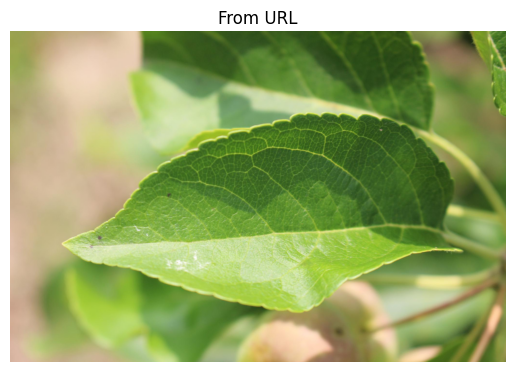

Predicted: healthy (95.96%)


In [19]:
url = "https://raw.githubusercontent.com/sakanaowo/PlantXViT/refs/heads/main/data/raw/plant-pathology-2020-fgvc7/images/Test_1101.jpg"
result = predict_image(url, model)


In [7]:
# embrapa from here
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import os

# === Tải lại nhãn từ thư mục train Embrapa ===
def load_embrapa_class_names(train_dir):
    dataset = datasets.ImageFolder(train_dir)
    class_names = dataset.classes
    return class_names

# === Hàm dự đoán ===
def predict_image_embrapa(image_path_or_url, model, class_names, device='cuda'):
    model.eval()
    model.to(device)

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    try:
        if image_path_or_url.startswith("http"):
            response = requests.get(image_path_or_url)
            image = Image.open(BytesIO(response.content)).convert("RGB")
            source = "URL"
        else:
            image = Image.open(image_path_or_url).convert("RGB")
            source = "Local"
    except Exception as e:
        print(f"Failed to load image: {e}")
        return None

    # Hiển thị ảnh
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Preview from ({source})")
    plt.show()

    # Tiền xử lý
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        top_prob, pred_class = torch.max(probs, dim=1)

    label = class_names[pred_class.item()]
    confidence = top_prob.item()

    print(f"Predicted: {label} ({confidence * 100:.2f}%)")
    return {
        'label': label,
        'confidence': confidence,
        'probabilities': probs.cpu().numpy()[0]
    }


In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import VGG16_Weights


# inception block (chỉnh sửa: tổng output channels = 512)
class InceptionBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.branch1x1 = nn.Conv2d(in_channels, 192, kernel_size=1)  # Tăng lên 192

        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, 160, kernel_size=(1, 3), padding=(0, 1)),
            nn.Conv2d(160, 160, kernel_size=(3, 1), padding=(1, 0)),
        )

        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, 160, kernel_size=1),  # Tăng lên 160
        )

    def forward(self, x):
        b1 = self.branch1x1(x)
        b2 = self.branch3x3(x)
        b3 = self.branch_pool(x)
        return torch.cat([b1, b2, b3], dim=1)  # Output shape: (B, 512, H, W)


# patch embedding: split patch -> Linear
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size=5, emb_size=16):
        super().__init__()
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.proj = nn.Linear(in_channels * patch_size * patch_size, emb_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 3, 1, 4, 5).contiguous()
        x = x.view(B, -1, C * self.patch_size * self.patch_size)
        return self.proj(x)  # shape: (b,num patches,emb size)


# -------- Transformer Encoder Block (ViT block) --------
class TransformerBlock(nn.Module):
    def __init__(self, emb_size=16, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_size)
        self.attn = nn.MultiheadAttention(emb_size, num_heads=2, batch_first=True)
        self.norm2 = nn.LayerNorm(emb_size)
        self.mlp = nn.Sequential(
            nn.Linear(emb_size, emb_size * 2),
            nn.GELU(),
            nn.Linear(emb_size * 2, emb_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x_attn, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + x_attn
        x = x + self.mlp(self.norm2(x))
        return x


# -------- PlantXViT Model --------
class PlantXViTembrapa(nn.Module):
    def __init__(self, num_classes=4, patch_size=5, emb_size=16, num_blocks=4, dropout=0.1):
        super().__init__()

        # VGG16 (2 blocks)
        vgg = models.vgg16(weights=VGG16_Weights.DEFAULT)
        self.vgg_block = nn.Sequential(*list(vgg.features[:10]))
        # self.vgg_block = nn.Sequential(*vgg[:10])  # output: (B, 128, 56, 56)

        # Inception-like block → (B, 384, 56, 56)
        self.inception = InceptionBlock(in_channels=128)

        # Patch Embedding → (B, 121, 16)
        # self.patch_embed = PatchEmbedding(in_channels=384, patch_size=patch_size, emb_size=emb_size)
        self.patch_embed = PatchEmbedding(in_channels=512, patch_size=patch_size, emb_size=emb_size)

        # Transformer blocks
        self.transformer = nn.Sequential(*[TransformerBlock(emb_size, dropout) for _ in range(num_blocks)])

        # Classification head
        self.norm = nn.LayerNorm(emb_size)
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # (B, emb_size, 1)
        self.classifier = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        x = self.vgg_block(x)  # (B, 128, 56, 56)
        x = self.inception(x)  # (B, 384, 56, 56)
        x = self.patch_embed(x)  # (B, 121, 16)
        x = self.transformer(x)  # (B, 121, 16)
        x = self.norm(x)  # (B, 121, 16)
        x = x.permute(0, 2, 1)  # (B, 16, 121)
        x = self.global_pool(x).squeeze(-1)  # (B, 16)
        return self.classifier(x)  # (B, num_classes)


In [9]:

model = PlantXViTembrapa(num_classes=93)
model.load_state_dict(torch.load("./outputs/embrapa/models/plantxvit_best_embrapa.pth", map_location='cuda'))

class_names = load_embrapa_class_names("./data/raw/embrapa/train")


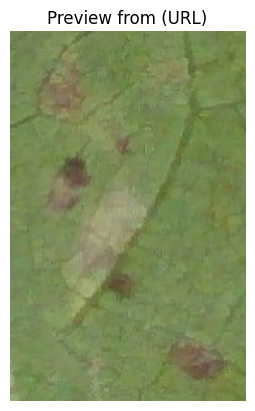

Predicted: Algod├úo (Cotton) - Ramularia (Areolate Mildew) - Cropped (99.59%)


In [10]:
image_path = "https://raw.githubusercontent.com/sakanaowo/PlantXViT/refs/heads/main/data/raw/embrapa/test/Algod%E2%94%9C%C3%BAo%20(Cotton)%20-%20Ramularia%20(Areolate%20Mildew)%20-%20Cropped/ramu006.jpg"
result = predict_image_embrapa(image_path, model, class_names)

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import VGG16_Weights


# inception block (chỉnh sửa: tổng output channels = 512)
# class InceptionBlock(nn.Module):
#     def __init__(self, in_channels):
#         super().__init__()
#         self.branch1x1 = nn.Conv2d(in_channels, 192, kernel_size=1)  # Tăng lên 192
#
#         self.branch3x3 = nn.Sequential(
#             nn.Conv2d(in_channels, 160, kernel_size=(1, 3), padding=(0, 1)),
#             nn.Conv2d(160, 160, kernel_size=(3, 1), padding=(1, 0)),
#         )
#
#         self.branch_pool = nn.Sequential(
#             nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
#             nn.Conv2d(in_channels, 160, kernel_size=1),  # Tăng lên 160
#         )
#
#     def forward(self, x):
#         b1 = self.branch1x1(x)
#         b2 = self.branch3x3(x)
#         b3 = self.branch_pool(x)
#         return torch.cat([b1, b2, b3], dim=1)  # Output shape: (B, 512, H, W)
#

# patch embedding: split patch -> Linear

# inception refine
class InceptionBlock(nn.Module):
    def __init__(self, in_channels=128):
        super(InceptionBlock, self).__init__()
        # Nhánh 1: 1x1
        self.branch1x1 = nn.Sequential(
            nn.Conv2d(in_channels, 128, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        # Nhánh 2: 1x1 -> 3x1 + 1x3
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, 96, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.Conv2d(96, 128, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        # Nhánh 3: 1x1 -> 3x1 + 1x3 -> 3x1 + 1x3
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 96, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.Conv2d(96, 96, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.Conv2d(96, 192, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(192),
            nn.Conv2d(192, 192, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(192)
        )

        # Nhánh 4: MaxPool -> 1x1
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, 64, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

    def forward(self, x):
        b1 = self.branch1x1(x)
        b2 = self.branch3x3(x)
        b3 = self.branch5x5(x)
        b4 = self.branch_pool(x)
        return torch.cat([b1, b2, b3, b4], dim=1)


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size=5, emb_size=16):
        super().__init__()
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.proj = nn.Linear(in_channels * patch_size * patch_size, emb_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 3, 1, 4, 5).contiguous()
        x = x.view(B, -1, C * self.patch_size * self.patch_size)
        return self.proj(x)  # shape: (b,num patches,emb size)


# -------- Transformer Encoder Block (ViT block) --------
class TransformerBlock(nn.Module):
    def __init__(self, emb_size=16, dropout=0.3):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_size)
        self.attn = nn.MultiheadAttention(emb_size, num_heads=2, batch_first=True)
        self.norm2 = nn.LayerNorm(emb_size)
        self.mlp = nn.Sequential(
            nn.Linear(emb_size, emb_size * 2),
            nn.GELU(),
            nn.Linear(emb_size * 2, emb_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x_attn, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + x_attn
        x = x + self.mlp(self.norm2(x))
        return x


# -------- PlantXViT Model --------
class PlantXViTplant(nn.Module):
    def __init__(self, num_classes=4, patch_size=5, emb_size=16, num_blocks=4, dropout=0.1):
        super().__init__()

        # VGG16 (2 blocks)
        vgg = models.vgg16(weights=VGG16_Weights.DEFAULT)
        self.vgg_block = nn.Sequential(*list(vgg.features[:10]))
        # self.vgg_block = nn.Sequential(*vgg[:10])  # output: (B, 128, 56, 56)

        # Inception-like block → (B, 384, 56, 56)
        self.inception = InceptionBlock(in_channels=128)

        # Patch Embedding → (B, 121, 16)
        # self.patch_embed = PatchEmbedding(in_channels=384, patch_size=patch_size, emb_size=emb_size)
        self.patch_embed = PatchEmbedding(in_channels=512, patch_size=patch_size, emb_size=emb_size)

        # Transformer blocks
        self.transformer = nn.Sequential(*[TransformerBlock(emb_size, dropout) for _ in range(num_blocks)])

        # Classification head
        self.norm = nn.LayerNorm(emb_size)
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # (B, emb_size, 1)
        self.classifier = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        x = self.vgg_block(x)  # (B, 128, 56, 56)
        x = self.inception(x)  # (B, 384, 56, 56)
        x = self.patch_embed(x)  # (B, 121, 16)
        x = self.transformer(x)  # (B, 121, 16)
        x = self.norm(x)  # (B, 121, 16)
        x = x.permute(0, 2, 1)  # (B, 16, 121)
        x = self.global_pool(x).squeeze(-1)  # (B, 16)
        return self.classifier(x)  # (B, num_classes)


In [12]:
def load_plant_class_names(train_dir):
    dataset = datasets.ImageFolder(train_dir)
    class_names = dataset.classes
    return class_names

# === Hàm dự đoán ===
def predict_image_plant(image_path_or_url, model, class_names, device='cuda'):
    model.eval()
    model.to(device)

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    try:
        if image_path_or_url.startswith("http"):
            response = requests.get(image_path_or_url)
            image = Image.open(BytesIO(response.content)).convert("RGB")
            source = "URL"
        else:
            image = Image.open(image_path_or_url).convert("RGB")
            source = "Local"
    except Exception as e:
        print(f"Failed to load image: {e}")
        return None

    # Hiển thị ảnh
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Preview from ({source})")
    plt.show()

    # Tiền xử lý
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        top_prob, pred_class = torch.max(probs, dim=1)

    label = class_names[pred_class.item()]
    confidence = top_prob.item()

    print(f"Predicted: {label} ({confidence * 100:.2f}%)")
    return {
        'label': label,
        'confidence': confidence,
        'probabilities': probs.cpu().numpy()[0]
    }


In [13]:

model = PlantXViTplant(num_classes=38)
model.load_state_dict(torch.load("./outputs/plantVillage/models/plantxvit_best_plantvillage.pth", map_location='cuda'))

class_names = load_plant_class_names("./data/raw/plantvillage/train")


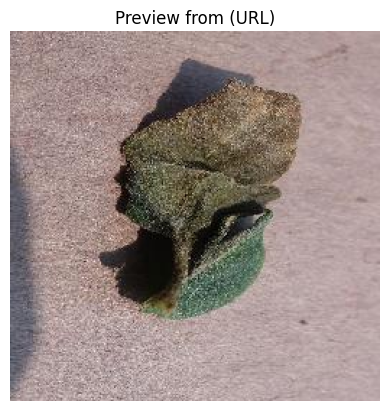

Predicted: Tomato___Late_blight (99.73%)


In [14]:
image_path = "https://raw.githubusercontent.com/sakanaowo/PlantXViT/refs/heads/main/data/raw/plantvillage/test/Tomato___Late_blight/7616d956-c144-4105-9972-5f747c5159a6___RS_Late.B 5600.JPG"
result = predict_image_plant(image_path, model, class_names)